# Can we get NUTS to work with numpyro?

NUTS is No-U-Turn-Sampling, an MCMC sampler.  Can we get it to work with GPyTorch?  NUTS requires Pyro, the probabilistic programming language built on PyTorch, but it's not clear that the Pyro programming language and support GPyTorch likelihood objects...

In [1]:
import os
if os.cpu_count() >= 4:
    # set this XLA flags to run 4 chains MCMC in parallel
    os.environ['XLA_FLAGS'] = '--xla_force_host_platform_device_count=4'

In [2]:
import jax.numpy as np
from jax import random
import numpy as onp
import seaborn as sns

import numpyro
import numpyro.distributions as dist
from numpyro.mcmc import MCMC, NUTS

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

Make synthetic noisy dataset with known parameters and known coefficients.

In [4]:
t_vec = np.linspace(0, 40, 2000)

/Users/obsidian/anaconda3/envs/gpytorch_dev/lib/python3.7/site-packages/jax/lib/xla_bridge.py:114: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [5]:
a_true = 0.2
b_true = 0.3
c_true = -7
sigma_true = 10.3
known_variance = sigma_true**2

In [6]:
y_true = a_true*t_vec**2 + b_true*t_vec + c_true

In [7]:
noise = onp.random.normal(0, sigma_true, size=len(y_true))
y_obs = y_true + noise

Let's get the least squares estimate.

In [8]:
A_mat = np.vander(t_vec, 3)
ATA = np.dot(A_mat.T, A_mat/known_variance)
sigma_w = np.linalg.inv(ATA)
mean_w = np.linalg.solve(ATA, np.dot(A_mat.T, y_obs/known_variance))

In [9]:
mean_w

DeviceArray([ 0.19899912,  0.35533798, -7.40826941], dtype=float32)

In [10]:
lst_sq_mean_fit = np.dot(A_mat, mean_w)

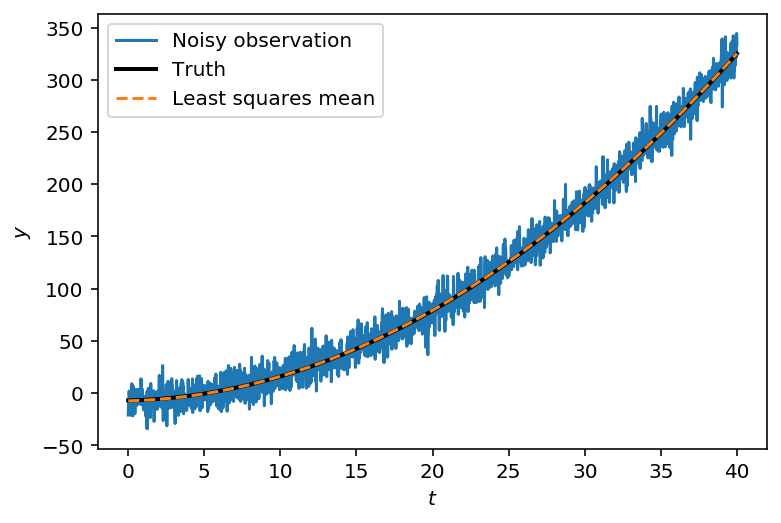

In [11]:
plt.plot(t_vec, y_obs, label='Noisy observation')
plt.plot(t_vec, y_true, label='Truth', color='k', lw=2)
plt.plot(t_vec, lst_sq_mean_fit, label='Least squares mean', linestyle='dashed')
plt.xlabel('$t$')
plt.ylabel('$y$')
plt.legend();

Ok, we have a dataset to work with.

In [12]:
lstsq_samples = onp.random.multivariate_normal(mean_w, sigma_w, size=5000)

/Users/obsidian/anaconda3/envs/gpytorch_dev/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: covariance is not positive-semidefinite.
  """Entry point for launching an IPython kernel.


In [13]:
lstsq_samples.shape

(5000, 3)

# Pyro and HMC

The model is:

$y = a t^2 + b t + c$


In [14]:
def model(time_values, y_values):
    aa = numpyro.sample("a", dist.Normal(0, 5000))
    bb = numpyro.sample("b", dist.Normal(0, 5000))
    cc = numpyro.sample("c", dist.Normal(0., 5000.0))
    #sigma = numpyro.sample("sigma", dist.Uniform(10.0, 11.0))
    mean = aa * time_values**2 + bb * time_values + cc
    numpyro.sample("obs", dist.Normal(mean, 10.3), obs=y_values)

Configure the MCMC.

In [15]:
rng = random.PRNGKey(0)
rng, rng_ = random.split(rng)

num_warmup, num_samples = 5000, 5000

# Run NUTS.
kernel = NUTS(model)
mcmc = MCMC(kernel, num_warmup, num_samples, num_chains=4, progress_bar=True)

Run the MCMC.

In [16]:
%%time
mcmc.run(rng_, t_vec, y_obs)

CPU times: user 6.94 s, sys: 168 ms, total: 7.11 s
Wall time: 6.84 s


In [17]:
truth_mapper = {'a':a_true, 'b':b_true, 'c':c_true}

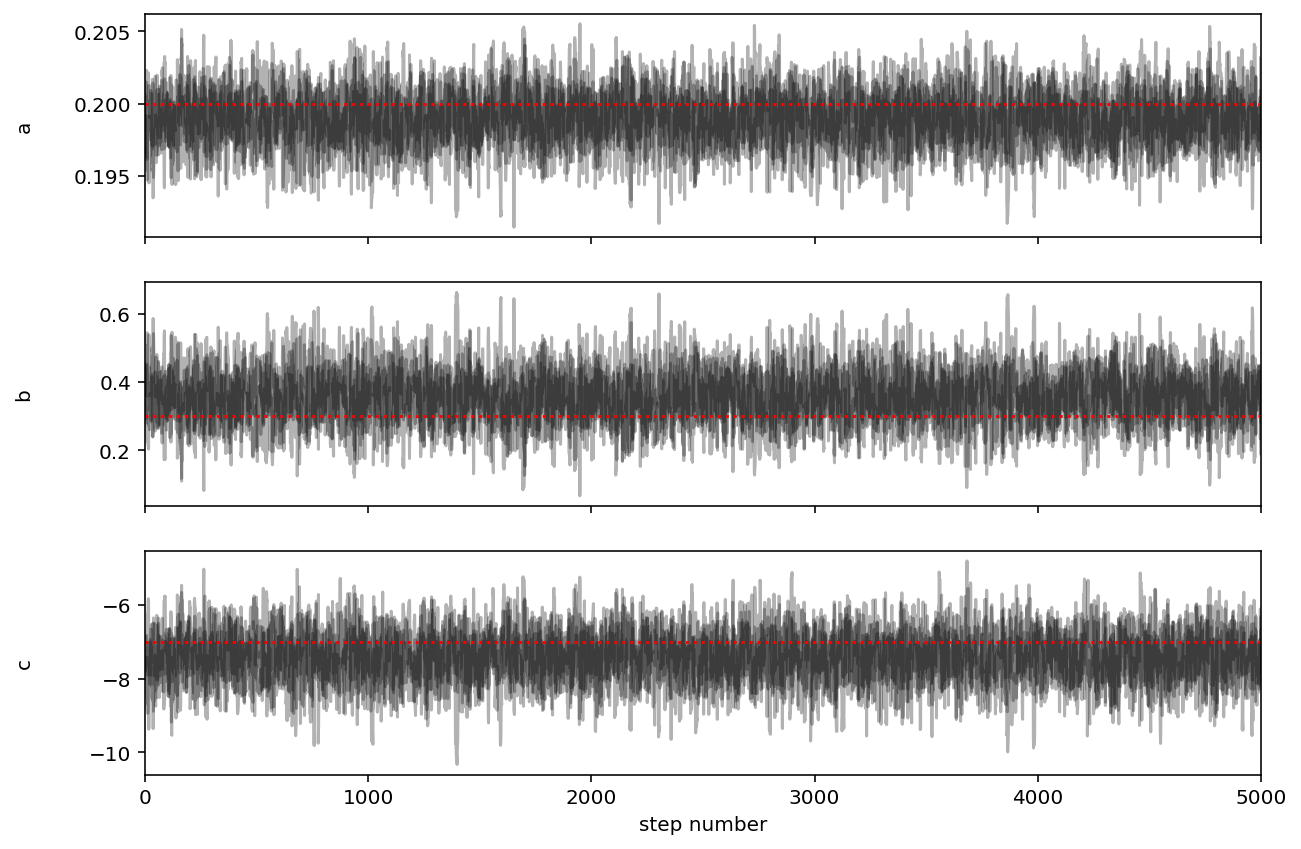

In [18]:
fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
samples = mcmc.get_samples(group_by_chain=True)
labels = ['a', 'b', 'c']
for i, lab in enumerate(labels):
    ax = axes[i]
    ax.plot(samples[lab].T, "k", alpha=0.3)
    ax.set_xlim(0, num_samples)
    ax.axhline(truth_mapper[lab], color='r', linestyle='dotted')
    ax.set_ylabel(lab)
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

Healthy looking MCMC chains envelope the true value.

In [19]:
#import scipy

#xx = np.linspace(0.19, 0.2075, 1000)
#func = scipy.stats.norm(loc=mean_w[0], scale=sigma_w[0, 0]).pdf(xx)

In [20]:
samples_1 = mcmc.get_samples()

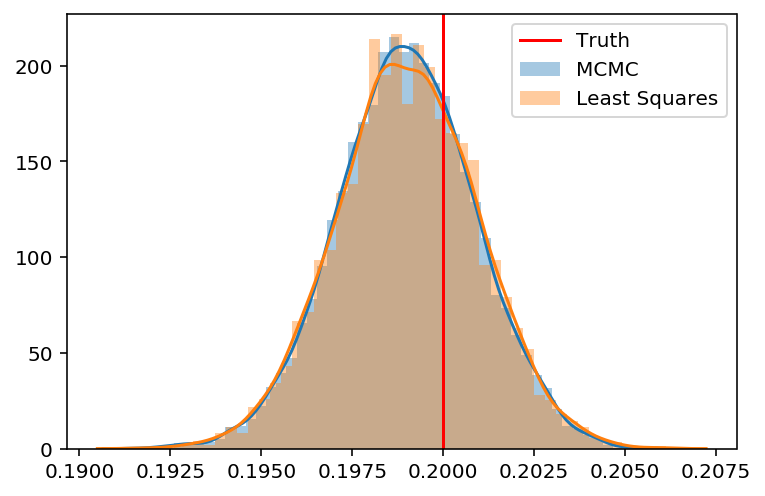

In [21]:
ax = sns.distplot(samples_1['a'].reshape(-1), label='MCMC')
sns.distplot(lstsq_samples[:, 0], ax=ax, label='Least Squares')
ax.axvline(a_true, color='r', label='Truth')
plt.legend();

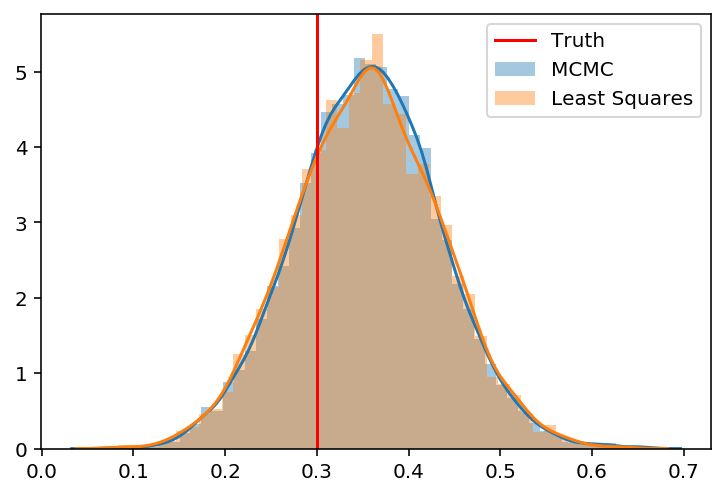

In [22]:
ax = sns.distplot(samples_1['b'].reshape(-1), label='MCMC')
sns.distplot(lstsq_samples[:, 1], ax=ax, label='Least Squares')
ax.axvline(b_true, color='r', label='Truth')
plt.legend();

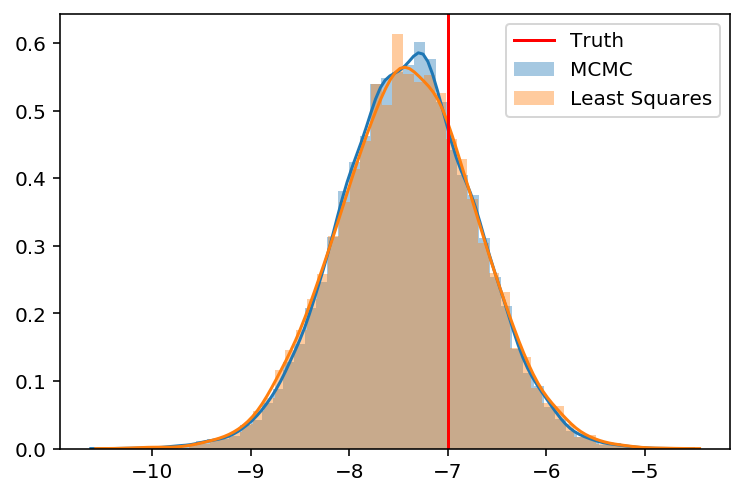

In [23]:
ax = sns.distplot(samples_1['c'].reshape(-1), label='MCMC')
sns.distplot(lstsq_samples[:, 2], ax=ax, label='Least Squares')
ax.axvline(c_true, color='r', label='Truth')
plt.legend();

/Users/obsidian/anaconda3/envs/gpytorch_dev/lib/python3.7/site-packages/jax/lax/lax.py:4435: UserWarning: Explicitly requested dtype <class 'numpy.float64'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))


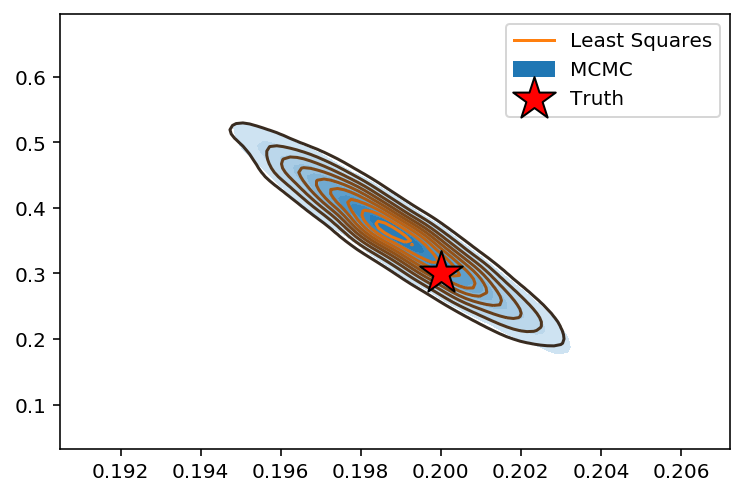

In [24]:
ax = sns.kdeplot(data=samples_1['a'].reshape(-1), data2=samples_1['b'].reshape(-1), shade=True, shade_lowest=False, label='MCMC')
sns.kdeplot(lstsq_samples[:, 0], lstsq_samples[:, 1], ax=ax, label='Least Squares')
ax.scatter([0.2], [0.3], color='r', marker='*', s=500,ec='k', alpha=1, zorder=10, label='Truth')
plt.legend()

Nice!  We get the right answer with MCMC!  And it's pretty fast!